In [24]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer,mean_squared_error,mean_absolute_error
from sklearn.svm import SVR
from skopt import BayesSearchCV

In [34]:
from IPython.display import display,HTML
show_html=lambda html: display(HTML(html))

# Load the Dataset

In [2]:
df=pd.read_csv('energy.csv',index_col=0)

#Display all columns of the dataset
pd.set_option('display.max_columns',None)

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9       

In [4]:
df.shape

(19735, 29)

In [5]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [6]:
df.describe(include='all')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,11-01-2016 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769


In [7]:
#Prediction Variable
energy=df.loc[:,'Appliances']
energy.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

# Splitting the Dataset

In [8]:
e_train,e_test=energy.iloc[:12000],energy.iloc[12000:]

print(e_train.shape)
print(e_test.shape)

(12000,)
(7735,)


In [9]:
#Time series prediction
#Predict values at a given time based on the previous values
#Make data matrix of size w+1 so window can be slided for prediction to be made at first and last position

w=4

#Normalize so value are between 0 and 1
scaler=MinMaxScaler()
#Reshaping into a column vector
e_train_s=scaler.fit_transform(e_train.to_numpy().reshape(-1,1))
e_test_s=scaler.transform(e_test.to_numpy().reshape(-1,1))

#Sliding window for train and test
window_train=sliding_window_view(e_train_s,w+1,axis=0).copy()
#X holds previous values used to make prediction, Y holds data to be predicted
#Squeeze function used to remove redundant values
X_train_w,Y_train_w=window_train.squeeze()[:,:-1],window_train.squeeze()[:,-1]

window_test=sliding_window_view(e_test_s,w+1,axis=0).copy()
X_test_w,Y_test_w=window_test.squeeze()[:,:-1],window_test.squeeze()[:,-1]

In [10]:
print('X-train:',X_train_w.shape)
print('Y-train:',Y_train_w.shape)
print('X-test:',X_test_w.shape)
print('Y-test:',Y_test_w.shape)

X-train: (11996, 4)
Y-train: (11996,)
X-test: (7731, 4)
Y-test: (7731,)


In [11]:
print(e_train.head())

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64


In [14]:
print(e_train_s[:5])

[[0.04672897]
 [0.04672897]
 [0.03738318]
 [0.03738318]
 [0.04672897]]


# Support Vector Machine

In [26]:
#Regularization parameter whose values must be strictly positive
#Epsilon for scaling data between 0 and 1,giving minimum value to generate regression
params={'C':10**np.linspace(-3,3,101),
       'epsilon':np.linspace(0,0.1,11)}

svr=SVR(kernel='linear',max_iter=10000,cache_size=2000)
svr_search=BayesSearchCV(svr,params,n_iter=20,cv=TimeSeriesSplit(n_splits=5,gap=w+1),
                         scoring=make_scorer(mean_squared_error,greater_is_better=False),
                         n_jobs=-1,refit=True,random_state=0)

svr_search.fit(X_train_w,Y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='linear', max_iter=10000),
              n_iter=20, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1....
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])})

In [37]:
show_html(pd.DataFrame(svr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head(10).to_html())

,params,mean_test_score,rank_test_score
19,"{'C': 0.12589254117941676, 'epsilon': 0.03}",-0.003863,1
16,"{'C': 0.1096478196143185, 'epsilon': 0.02}",-0.003867,2
14,"{'C': 0.03630780547701014, 'epsilon': 0.02}",-0.003892,3
12,"{'C': 23.9883291901949, 'epsilon': 0.03}",-0.003911,4
4,"{'C': 0.023988329190194897, 'epsilon': 0.02}",-0.003931,5
9,"{'C': 0.16595869074375597, 'epsilon': 0.04}",-0.003969,6
2,"{'C': 1.513561248436207, 'epsilon': 0.0}",-0.003977,7
15,"{'C': 15.848931924611142, 'epsilon': 0.02}",-0.003985,8
7,"{'C': 1.1481536214968828, 'epsilon': 0.05}",-0.004199,9
11,"{'C': 0.006918309709189363, 'epsilon': 0.01}",-0.004306,10


# Evaluation on Test Set

In [38]:
mean_squared_error(Y_test_w,svr_search.predict(X_test_w))

0.003616861294028365

In [39]:
mean_absolute_error(Y_test_w,svr_search.predict(X_test_w))

0.026864224452546052

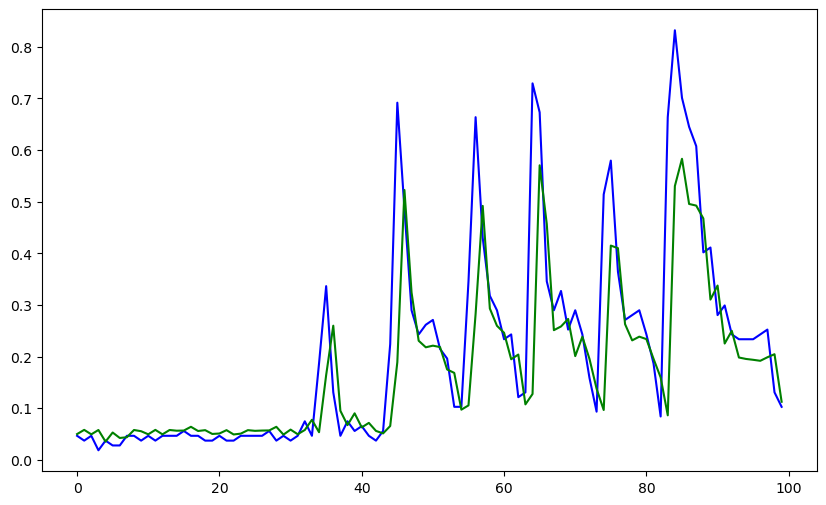

In [42]:
plt.figure(figsize=(10,6))
plt.plot(Y_test_w[:100],'b')
plt.plot(svr_search.predict(X_test_w[:100]),'g')